Loading dataset...
Found 900 files belonging to 6 classes.
Using 720 files for training.
Found 900 files belonging to 6 classes.
Using 180 files for validation.
Found 6 classes: ['Moon_jellyfish', 'barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish']

Building ResNet50 from scratch...

Loading weights from /content/drive/MyDrive/resnet50_weights_tf_dim_ordering_tf_kernels.h5...
Weights loaded successfully!

Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


Training model (frozen base)...
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 254s 11s/step - accuracy: 0.2711 - loss: 2.2911 - val_accuracy: 0.6944 - val_loss: 0.8522
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.6672 - loss: 0.9136 - val_accuracy: 0.7833 - val_loss: 0.5669
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.7794 - loss: 0.5880 - val_accuracy: 0.8278 - val_loss: 0.4252
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.8516 - loss: 0.4300 - val_accuracy: 0.8556 - val_loss: 0.4085
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8852 - loss: 0.3355 - val_accuracy: 0.8667 - val_loss: 0.3493
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.8960 - loss: 0.2793 - val_accuracy: 0.8889 - val_loss: 0.2916
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.9397 - loss: 0.2040 - val_accuracy: 0.8944 - val_loss: 0.2874
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9453 

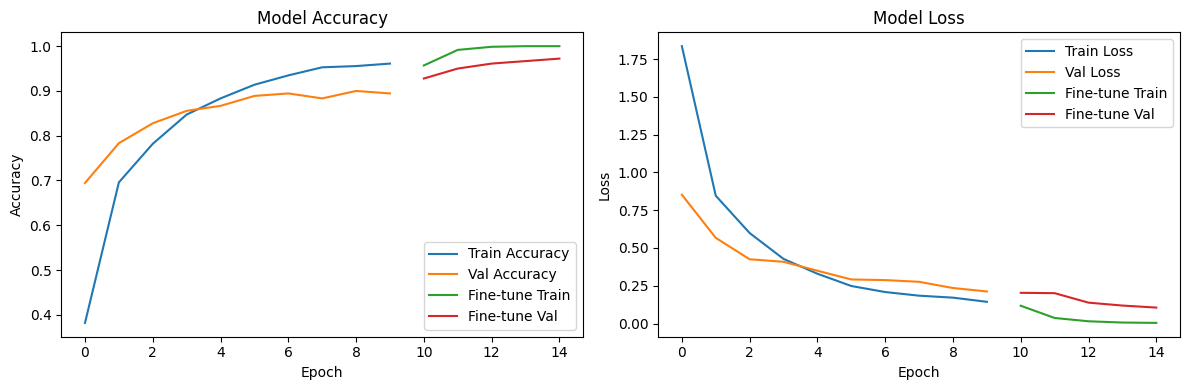

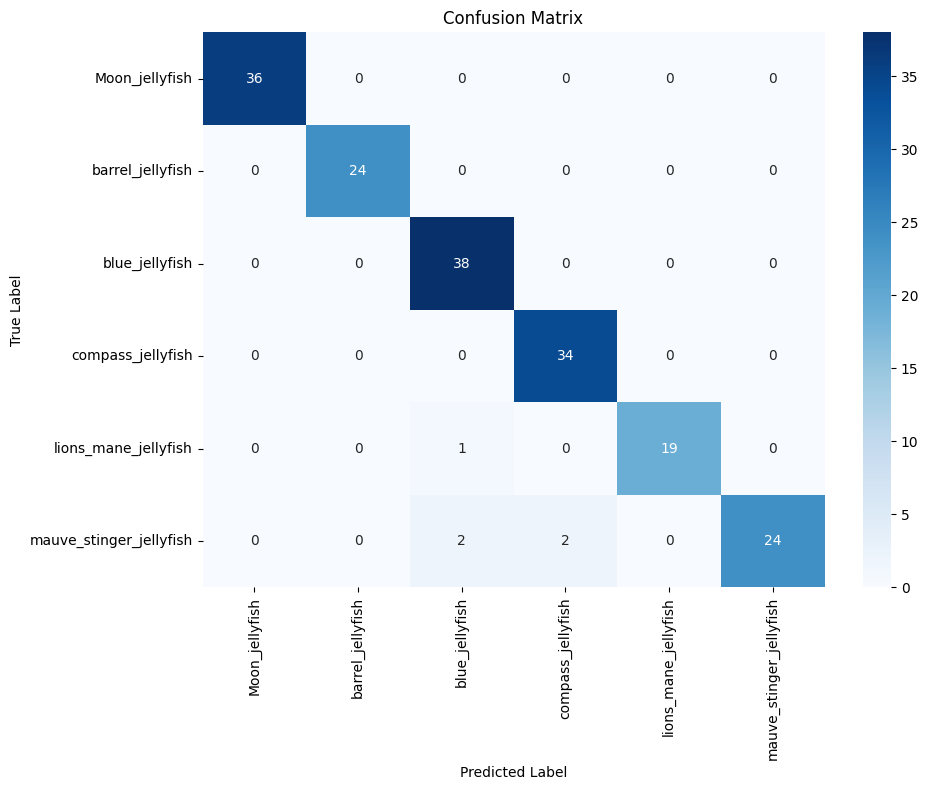

In [1]:
import os
import numpy as np
from pathlib import Path
import keras
from keras import layers, models, optimizers
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Configuration
DATA_PATH = r"/content/drive/MyDrive/concave"
WEIGHTS_PATH = r"/content/drive/MyDrive/resnet50_weights_tf_dim_ordering_tf_kernels.h5"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

# ResNet50 Architecture from scratch
def identity_block(x, filters, stage, block):
    """Identity block without conv shortcut"""
    f1, f2, f3 = filters
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x_shortcut = x

    # First layer
    x = layers.Conv2D(f1, (1, 1), name=conv_name_base + '2a')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    # Second layer
    x = layers.Conv2D(f2, (3, 3), padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    # Third layer
    x = layers.Conv2D(f3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    # Add shortcut
    x = layers.Add()([x, x_shortcut])
    x = layers.Activation('relu')(x)

    return x

def conv_block(x, filters, stage, block, strides=(2, 2)):
    """Conv block with conv shortcut"""
    f1, f2, f3 = filters
    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x_shortcut = x

    # First layer
    x = layers.Conv2D(f1, (1, 1), strides=strides, name=conv_name_base + '2a')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    # Second layer
    x = layers.Conv2D(f2, (3, 3), padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    # Third layer
    x = layers.Conv2D(f3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    # Shortcut path
    x_shortcut = layers.Conv2D(f3, (1, 1), strides=strides, name=conv_name_base + '1')(x_shortcut)
    x_shortcut = layers.BatchNormalization(name=bn_name_base + '1')(x_shortcut)

    # Add shortcut
    x = layers.Add()([x, x_shortcut])
    x = layers.Activation('relu')(x)

    return x

def ResNet50(input_shape=(224, 224, 3), include_top=False):
    """Build ResNet50 from scratch"""
    inputs = layers.Input(shape=input_shape)

    # Stage 1
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(inputs)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Stage 2
    x = conv_block(x, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, [64, 64, 256], stage=2, block='c')

    # Stage 3
    x = conv_block(x, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, [128, 128, 512], stage=3, block='d')

    # Stage 4
    x = conv_block(x, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    x = conv_block(x, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, [512, 512, 2048], stage=5, block='c')

    if not include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)

    model = models.Model(inputs, x, name='resnet50')
    return model

# Preprocessing function
def preprocess_input(x):
    """Preprocess input like ImageNet (BGR and zero-center)"""
    # Convert RGB to BGR
    x = x[..., ::-1]
    # Zero-center by mean pixel
    mean = [103.939, 116.779, 123.68]
    x = x - mean
    return x

# Load dataset
print("Loading dataset...")
train_ds = image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    DATA_PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Get class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# Optimize dataset performance
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Build model
print("\nBuilding ResNet50 from scratch...")
inputs = layers.Input(shape=(224, 224, 3))

# Preprocessing layer
x = layers.Lambda(lambda img: preprocess_input(img))(inputs)

# Build ResNet50 base
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False)

# Get features
features = base_model(x)

# Add classification head
x = layers.Dropout(0.5)(features)
outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model = models.Model(inputs=inputs, outputs=outputs)

# Load pre-trained weights
print(f"\nLoading weights from {WEIGHTS_PATH}...")
try:
    base_model.load_weights(WEIGHTS_PATH, by_name=True, skip_mismatch=True)
    print("Weights loaded successfully!")
except Exception as e:
    print(f"Warning: Could not load all weights: {e}")
    print("Continuing with random initialization...")

# Freeze base model layers initially
base_model.trainable = False

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel summary:")
model.summary()

# Train model
print("\nTraining model (frozen base)...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

# Fine-tuning
print("\nFine-tuning model (unfreezing last layers)...")
base_model.trainable = True

# Freeze early layers, unfreeze last few
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

# Save model
model.save('resnet50_finetuned.keras')
print("\nModel saved as 'resnet50_finetuned.keras'")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(range(EPOCHS, EPOCHS+5), history_fine.history['accuracy'], label='Fine-tune Train')
plt.plot(range(EPOCHS, EPOCHS+5), history_fine.history['val_accuracy'], label='Fine-tune Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(range(EPOCHS, EPOCHS+5), history_fine.history['loss'], label='Fine-tune Train')
plt.plot(range(EPOCHS, EPOCHS+5), history_fine.history['val_loss'], label='Fine-tune Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.savefig('training_history.png')
print("Training history saved as 'training_history.png'")

# Evaluate on validation set
print("\nFinal evaluation:")
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Make predictions on a few samples
print("\nSample predictions:")
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    for i in range(min(5, len(images))):
        pred_class = class_names[np.argmax(predictions[i])]
        true_class = class_names[labels[i].numpy()]
        confidence = np.max(predictions[i]) * 100
        print(f"True: {true_class}, Predicted: {pred_class}, Confidence: {confidence:.2f}%")

# Generate predictions for entire validation set
print("\nGenerating predictions for confusion matrix and classification report...")
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("\nConfusion matrix saved as 'confusion_matrix.png'")

# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Save classification report to file
with open('classification_report.txt', 'w') as f:
    f.write("CLASSIFICATION REPORT\n")
    f.write("="*50 + "\n")
    f.write(report)
print("\nClassification report saved as 'classification_report.txt'")